<a href="https://colab.research.google.com/github/SuhaibIrsheidat/Brain-Tumor-Detection/blob/master/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import glob
import matplotlib.pyplot as plt
from random import shuffle
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [0]:
# Globals
Data_Dir = '/content/drive/My Drive/Colab Notebooks/data/'
IMG_SIZE = (256,256)
LEARNING_RATE = 1e-3
LABELS = {'YES': [1,0], 'NO': [0,1]}
TRAIN_RATE = 0.85

In [0]:
def initData():
    data = list()
    for img in glob.glob(Data_Dir + 'yes' + '/*.jpg'):
        img_data = cv.imread(img, cv.IMREAD_GRAYSCALE)
        img_data = cv.resize(img_data, IMG_SIZE)
        data.append([np.array(img_data), LABELS['YES']])
    for img in glob.glob(Data_Dir + 'no' + '/*.jpg'):
        img_data = cv.imread(img, cv.IMREAD_GRAYSCALE)
        img_data = cv.resize(img_data, IMG_SIZE)
        data.append([np.array(img_data), LABELS['NO']])
    shuffle(data)
    return data

In [0]:
def splittingData(data):
    shuffle(data)
    train_data = np.array(data[: int(len(data)*TRAIN_RATE)])
    test_data = data[int(len(data)*TRAIN_RATE):]
    X_train = np.array([i[0] for i in train_data]).reshape(-1, 256, 256, 1)
    Y_train = np.array([i[1] for i in train_data])
    X_test = np.array([i[0] for i in test_data]).reshape(-1, 256, 256, 1)
    Y_test = np.array([i[1] for i in test_data])
    return (X_train, Y_train, X_test, Y_test)

In [0]:
data = initData()
X_train, Y_train, X_test, Y_test = splittingData(data)

In [7]:
# Constructing the graph
tf.reset_default_graph()
conv = input_data(shape=[None, 256, 256, 1], name='input')
conv = conv_2d(conv, 32, 5, activation="relu")
conv = max_pool_2d(conv, 5)
conv = conv_2d(conv, 64, 5, activation="relu")
conv = max_pool_2d(conv, 5)
conv = conv_2d(conv, 128, 5, activation="relu")
conv = max_pool_2d(conv, 5)
conv = conv_2d(conv, 64, 5, activation="relu")
conv = max_pool_2d(conv, 5)
conv = conv_2d(conv, 32, 5, activation="relu")
conv = max_pool_2d(conv, 5)
conv = fully_connected(conv, 1024, activation="relu")
conv = dropout(conv, 0.8)
conv = fully_connected(conv, 2, activation="softmax")
conv = regression(conv, optimizer='adam', learning_rate=LEARNING_RATE, batch_size=128, loss='categorical_crossentropy', shuffle_batches=True)
model = tflearn.DNN(conv, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, Y_train, n_epoch=100, validation_set=({'input': X_test}, Y_test), snapshot_step=500, run_id='Brain Tumor Detection', show_metric=True)


Training Step: 199  | total loss: 0.07747 | time: 6.855s
| Adam | epoch: 100 | loss: 0.07747 - acc: 0.9882 -- iter: 128/141
Training Step: 200  | total loss: 0.07845 | time: 8.605s
| Adam | epoch: 100 | loss: 0.07845 - acc: 0.9878 | val_loss: 0.17015 - val_acc: 0.8800 -- iter: 141/141
--
INFO:tensorflow:/content/Model.tflearn is not in all_model_checkpoint_paths. Manually adding it.


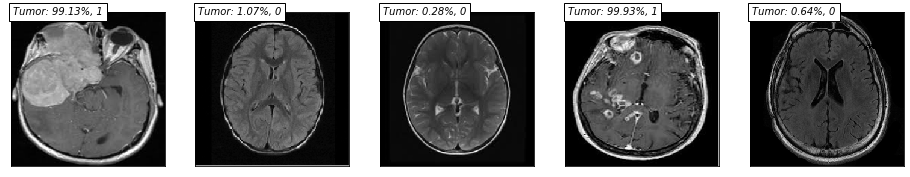

Test accuarcy: 88.0000%


In [38]:
# Visualize
fig = plt.figure(figsize=(16,12))
for i in range(20,25):
    y = fig.add_subplot(1, 5,i-19)
    y.imshow(X_test[i].reshape(256,256), cmap='gray')
    X = X_test[i].reshape(-1, 256, 256, 1)
    model_out = model.predict(X)[0]
    
    label = 'Tumor: %0.2f%%' % (model_out[0]*100)
    label += ', ' + str(Y_test[i][0])
    
    plt.text(4,4, label, style='italic', bbox = {'facecolor': 'white'})
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.savefig("/content/drive/My Drive/Colab Notebooks/figures/Results5.png")
plt.show()
score = model.evaluate(X_test, Y_test)
print('Test accuarcy: %0.4f%%' % (score[0] * 100))
